### Step 1: Load the datasets

In [18]:
import pandas as pd

fills_data = pd.read_parquet("datasets/fills_data.parq")
market_data = pd.read_parquet("datasets/market_data.parq")

### Step 2: Preprocessing
Here, we will be merging the `fills_data` and `market_data` datasets based on `timestamp`

In [ ]:
fills_data.index = pd.to_datetime(fills_data.index)
market_data.index = pd.to_datetime(market_data.index)

if fills_data.index.tz is None:
	fills_data.index = fills_data.index.tz_localize('UTC')
if market_data.index.tz is None:
	market_data.index = market_data.index.tz_localize('UTC')

fills_data['side'] = fills_data['side'].astype('category')
fills_data['liquidity'] = fills_data['liquidity'].astype('category')

fills_data = fills_data.sort_values('timestamp')
market_data = market_data.sort_values('timestamp')

merged_data = pd.merge_asof(
	fills_data.reset_index(),
	market_data.reset_index(),
	on='timestamp',
	direction='backward'
)

### Step 3: Feature Engineering

In [23]:
merged_data['mid_price'] = (merged_data['bid_prc'] + merged_data['ask_prc']) / 2
merged_data['q_i'] = merged_data['fill_qty'] * merged_data['side'].map({'B': 1, 'S': -1}).astype(int)
merged_data['trade_pnl'] = merged_data['q_i'] * (merged_data['mid_price'] - merged_data['fill_prc'])
merged_data['cumulative_pnl'] = merged_data['trade_pnl'].cumsum()

merged_data['trade_pnl_lag1'] = merged_data['trade_pnl'].shift(1)
merged_data['cumulative_pnl_lag1'] = merged_data['cumulative_pnl'].shift(1)
merged_data['balance_lag1'] = merged_data['balance'].shift(1)

merged_data['volatility'] = merged_data['mid_price'].rolling(window=20).std()
merged_data['volatility_lag1'] = merged_data['volatility'].shift(1)

mean_balance = merged_data['balance_lag1'].mean()
merged_data['dev_from_mean_balance_lag1'] = merged_data['balance_lag1'] - mean_balance
merged_data['dev_from_mean_balance_lag1_diff'] = merged_data['dev_from_mean_balance_lag1'].diff()

mean_mid_price = merged_data['mid_price'].rolling(window=100).mean().shift(1)
merged_data['dev_from_mean_mid_price_lag1'] = merged_data['mid_price'] - mean_mid_price
merged_data['dev_from_mean_mid_price_lag1_diff'] = merged_data['dev_from_mean_mid_price_lag1'].diff()

# Drop NA rows from lag/rolling features
merged_data = merged_data.dropna()

# Encode target
merged_data['target'] = merged_data['side'].map({'B': 1, 'S': 0})

### Step 4: Model Training

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

features = [
    'dev_from_mean_balance_lag1_diff',
    'dev_from_mean_mid_price_lag1_diff',
    'trade_pnl_lag1',
    'volatility_lag1',
    'fill_prc',
    'fill_qty'
]

X = merged_data[features]
y = merged_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       140
           1       0.76      0.66      0.71       167

    accuracy                           0.70       307
   macro avg       0.70      0.70      0.70       307
weighted avg       0.71      0.70      0.70       307



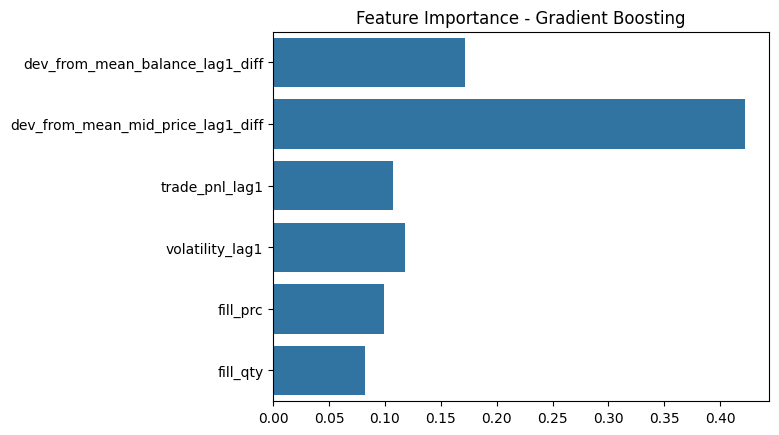

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

importance = model.feature_importances_
sns.barplot(x=importance, y=features)
plt.title("Feature Importance - Gradient Boosting")
plt.show()


### Step 6: Cross-Validation

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
scores = cross_val_score(model, X, y, cv=5, scoring='f1')

print("Cross-validated F1 scores:", scores)
print("Average F1 score:", scores.mean())

Cross-validated F1 scores: [0.74654378 0.65       0.71361502 0.67317073 0.71153846]
Average F1 score: 0.6989735991043601
